In [2]:
from itertools import takewhile

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import seaborn as sns

from IPython.display import display, Markdown

In [3]:
plt.rcParams.update({
    "axes.prop_cycle": plt.cycler("color", ['#000000', '#1b6989', '#e69f00', '#009e73', '#f0e442', '#50b4e9', '#d55e00', '#cc79a7']),
    "figure.figsize": [12.0, 5.0],
    "font.serif": ['Palatino',
                   'Palatino Linotype',
                   'Palatino LT STD',
                   'Book Antiqua',
                   'Georgia',
                   'DejaVu Serif'],
    'font.family': 'serif',
    'figure.facecolor': '#fffff8',
    'axes.facecolor': '#fffff8',
    'figure.constrained_layout.use': True,
    'font.size': 14.0,
    'hist.bins': 'auto',
    'lines.linewidth': 3.0,
    'lines.markeredgewidth': 2.0,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 8.0, 
})

# The problem with Bayes formula

Lets take a look at [Bayes formula](https://en.wikipedia.org/wiki/Bayes%27_theorem):

$$P(\theta|x) = \frac{P(x|\theta) P(\theta)}{P(x)}$$

We have $P(\theta|x)$, the probability of our model parameters $\theta$ given the data $x$ and thus our quantity of interest. To compute this we multiply the prior $P(\theta)$ (what we think about $\theta$ before we have seen any data) and the likelihood $P(x|\theta)$, i.e. how we think our data is distributed. This nominator is pretty easy to solve for.

However, lets take a closer look at the denominator. $P(x)$ which is also called the evidence (i.e. the evidence that the data x was generated by this model). We can compute this quantity by integrating over all possible parameter values:
$$P(x) = \int_\Theta P(x, \theta) \, \mathrm{d}\theta$$

This is the key difficulty with Bayes formula -- while the formula looks innocent enough, for even slightly non-trivial models you just can't compute the posterior in a closed-form way. 

So we can't evaluate Bayes formula. However, the numerator is usually quite easy to compute, because our priors are probability densities and so is our likelihood which are easy to evaluate. Let's define something *proportional* to our posterior:

$$\tilde{P}(\theta|x) =  P(x|\theta) P(\theta) $$

And let's assume we could somehow generate samples from this unnormalized distribution. In that case we could approximate it quite easily:

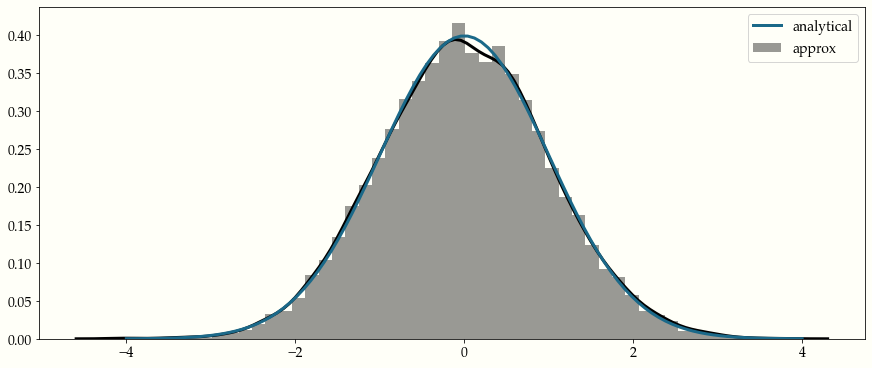

In [4]:
x = np.random.randn(10000) # sampling from normal distribution
sns.distplot(x, kde=True, label='approx');
x_eval = np.linspace(-4, 4, 100)
plt.plot(x_eval, st.norm().pdf(x_eval), label='analytical')
plt.legend();

## Inverse CDF sampling

The most direct method is to draw random samples from a uniform distribution and pass them through the inverse cumulative density function (CDF) of our posterior distribution.

Formally, the CDF is given by 

$$
\operatorname{cdf}(x) = \int_0^x p(t)~dt
$$

Note that the value $\operatorname{cdf}(x)$ is "the probability that a value is less than $x$", and is between 0 and 1. 

Text(0.5, 1.0, 'Normal cumulative density function')

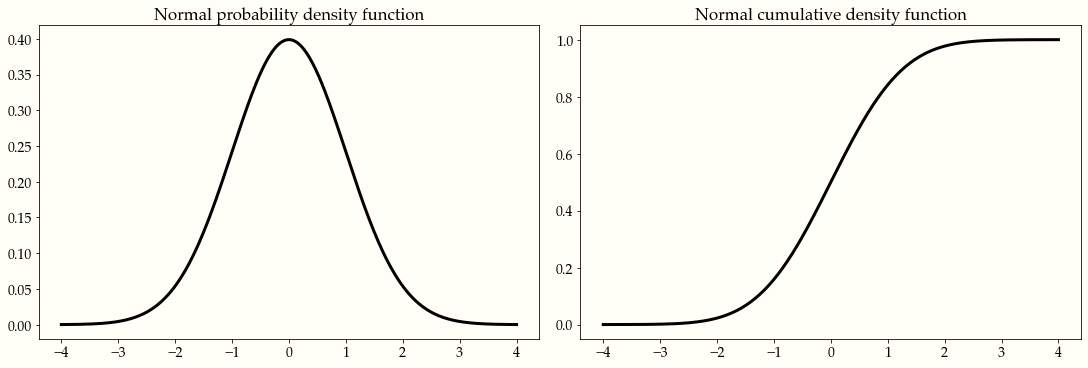

In [5]:
rv = st.norm(0, 1)

t = np.linspace(-4, 4, 300)

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

axes[0].plot(t, rv.pdf(t))
axes[0].set_title('Normal probability density function')
axes[1].plot(t, rv.cdf(t))
axes[1].set_title('Normal cumulative density function')

If we can *invert* the cumulative density function, we have a function $\operatorname{cdf}^{-1}(t)$, where $0 \leq t \leq 1$. We can use this function to draw random values:

1. Draw $u \sim U(0, 1)$
2. Use $y = \operatorname{cdf}^{-1}(u)$ as your sample

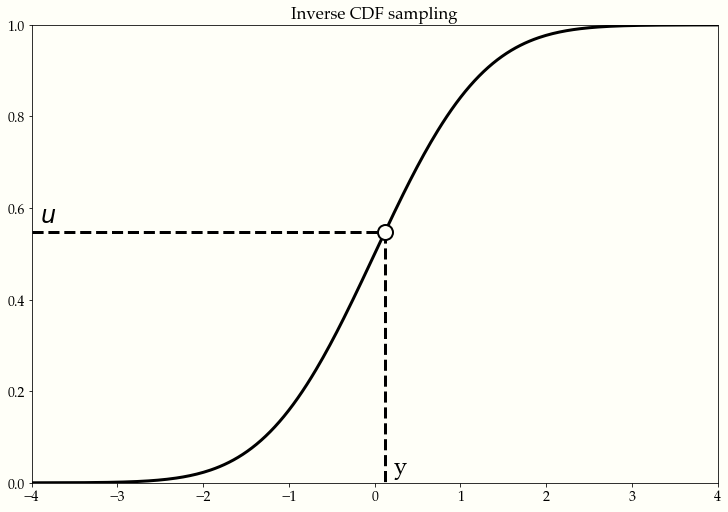

In [6]:
np.random.seed(0)
rv = st.norm(0, 1)

t = np.linspace(-4, 4, 300)
u = np.random.rand()

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(t, rv.cdf(t), color='C0')
ax.text(t.min() + 0.1, u + 0.02, '$u$', fontdict={"fontsize": 24})
ax.hlines(u, t.min(), rv.ppf(u), linestyles='dashed', color='C0')
ax.vlines(rv.ppf(u), u, 0, linestyles='dashed', color='C0')
bg_color = ax.get_facecolor()
ax.plot(rv.ppf(u), u, 'o', mfc=bg_color, ms=15)
ax.text(rv.ppf(u) + 0.1, 0.02, 'y', fontdict={"fontsize": 24})
ax.set_xlim(t.min(), t.max())
ax.set_ylim(0, 1)
ax.set_title('Inverse CDF sampling');

### Inverse CDF sampling homework: 

Fill out the following function that implements inverse CDF sampling. There is a cell below to visually check your implementation.

In [7]:
def sample(draws, inv_cdf):
    """Draw samples using the inverse CDF of a distribution.
    
    Parameters
    ----------
    draws : int
        Number of draws to return
    inv_cdf : function
        Gives the percentile of the distribution the argument falls in. This is vectorized, like in `scipy.stats.norm.ppf`"""
    # output should be an array of size (draws,), distributed according to inv_cdf
    ####################   
    return np.random.rand(draws)  # This is wrong, but it runs!
    #################### 

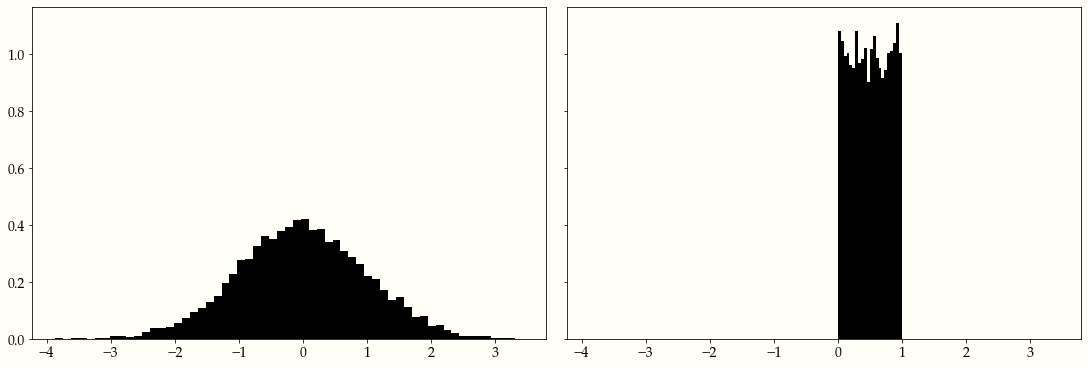

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), sharex=True, sharey=True)
draws = 10_000

# Two histograms should look the same
axes[0].hist(st.norm().rvs(draws), bins='auto', density=True)
axes[1].hist(sample(draws, st.norm().ppf), bins='auto', density=True);

But, we already mentioned that integration is *hard*. So we didn't actually solve our problem as now we not only have to integrate our posterior, we also have to *invert* it, which makes it even harder.

In addition, if we are iterating on a statistical model, we may want a method that works without requiring rederiving a formula for generating samples. 

Further, in Bayesian data analysis, we only have access to something proportional to our posterior, rather than the full posterior.

So what we need is a method that can work on $P(x|\theta) P(\theta)$, rather than $\frac{P(x|\theta) P(\theta)}{P(x)}$.

## Rejection Sampling

Rejection sampling is a very simple method to create samples from our target distribution without inversion. Intuitively, it works by sampling from an enveloping distribution we can easily sample from, like a normal, and then rejecting if the sample does not match the density of the target distribution. More formally:

1. Choose a proposal distribution $q$ that you know how to sample from.
2. Choose a number $k$, so that $kq(x) \geq \tilde{p}(x)$ for all $x$ (this is often difficult in practice).

Then, we repeatedly 

1. Draw a $z$ from $q$
2. Draw a $u$ from $\operatorname{Uniform}(0, kq(z))$
3. If $\tilde{p} > u$, accept the draw, otherwise, reject.

Importantly, every "rejection" is wasted computation! We will explore methods for having less wasted computation later.

In [9]:
def mixture_of_gaussians():
    rvs = (st.norm(-3, 1), st.norm(0, 1), st.norm(3, 1))
    probs = (0.5, 0.2, 0.3)
    def pdf(x):
        return sum(p * rv.pdf(x) for p, rv in zip(probs, rvs))
    return pdf

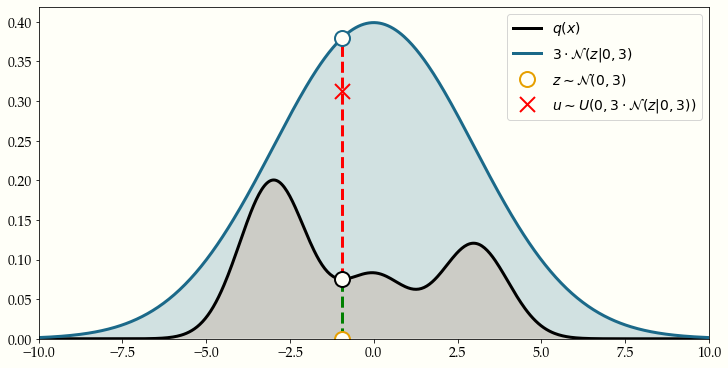

In [10]:
np.random.seed(6)
pdf = mixture_of_gaussians()
k = 3
q = st.norm(0, 3)
z = q.rvs()
u = np.random.rand() * k * q.pdf(z)

fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)

t = np.linspace(-10, 10, 500)
ax.plot(t, pdf(t), '-', label='$q(x)$')
ax.fill_between(t, 0, pdf(t), alpha=0.2)
ax.plot(t, k * q.pdf(t), '-', label='$3 \cdot \mathcal{N}(z | 0, 3)$')
ax.fill_between(t, pdf(t), 3 * q.pdf(t), alpha=0.2)

bg_color = ax.get_facecolor()
ax.vlines(z, 0, pdf(z), linestyles='dashed', color='green')
ax.vlines(z, pdf(z), k * q.pdf(z), linestyles='dashed', color='red')

ax.plot(z, 0, 'o', label='$z \sim \mathcal{N}(0, 3)$', ms=15, mfc=bg_color)
ax.plot(z, pdf(z), 'o', color='C0', ms=15, mfc=bg_color)
ax.plot(z, u, 'rx', label='$u \sim U(0, 3\cdot\mathcal{N}(z | 0, 3))$', ms=15, mfc=bg_color)
ax.plot(z, k * q.pdf(z), 'o', color='C1', ms=15, mfc=bg_color)

ax.set_ylim(bottom=0)
ax.set_xlim(t.min(), t.max())
ax.legend();

### Rejection Sampling Homework

Sample from the pdf returned by `mixture_of_gaussians` using rejection sampling. We will implement this as a Python generator, and yield the proposed draw, `z`, as well as whether it was accepted. You should assume `proposal_dist` comes from `scipy.stats`, so it has a `.rvs()` method that samples, and a `.pdf` method that evaluates the probability density function at a point.

If $kq(x)$ is not larger than $\tilde{p}(x)$, throw an exception!

The cell below has a plot to check your implementation.

In [11]:
def rejection_sampler(pdf, proposal_dist, k):
    """
    Yields proposals, and whether that proposal should be accepted or rejected
    """
    while True:
        z = proposal_dist.rvs()
        # Enter your code below
        ####################
        accept = True
        yield z, accept
        ####################

def gen_samples(draws, sampler):
    """An example of how to use the rejection sampler above."""
    samples = []
    for n_draws, (z, accept) in enumerate(sampler, 1):
        if accept:
            samples.append(z)
            if len(samples) == draws:
                return np.array(samples), n_draws

CPU times: user 615 ms, sys: 18.1 ms, total: 633 ms
Wall time: 715 ms


Text(0.5, 1.0, '10,000 draws from the pdf with 100.00% efficiency')

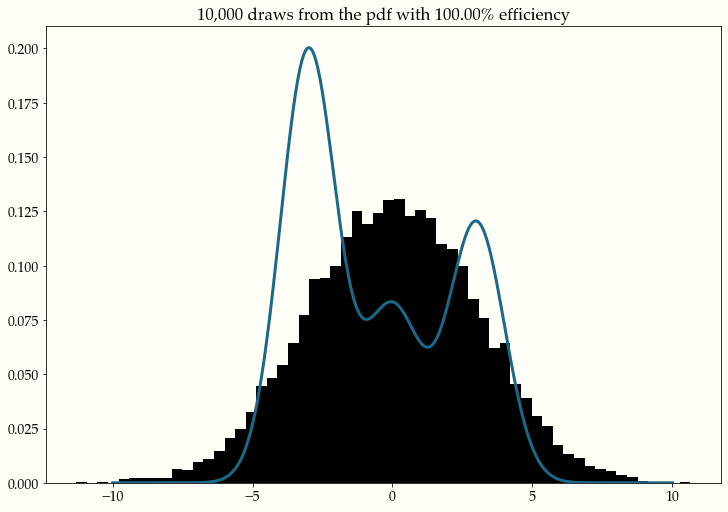

In [12]:
%%time

pdf = mixture_of_gaussians()
proposal_dist = st.norm(0, 3)
k = 3

samples, draws = gen_samples(10_000, rejection_sampler(pdf, proposal_dist, k))

fig, ax = plt.subplots(figsize=(10, 7))

t = np.linspace(-10, 10, 500)

# This histogram should look very similar to the pdf that is plotted
ax.hist(samples, bins='auto', density=True)
ax.plot(t, pdf(t))

ax.set_title(f'{samples.size:,d} draws from the pdf with {100 * samples.size / draws:.2f}% efficiency');

### How does a rejection sampler scale with dimension?

Use as your "unknown distribution" a multivariate Gaussian with identity covariance matrix, and use as your proposal distribution a multivariate Gaussian with covariance matrix `1.1 * I`. 

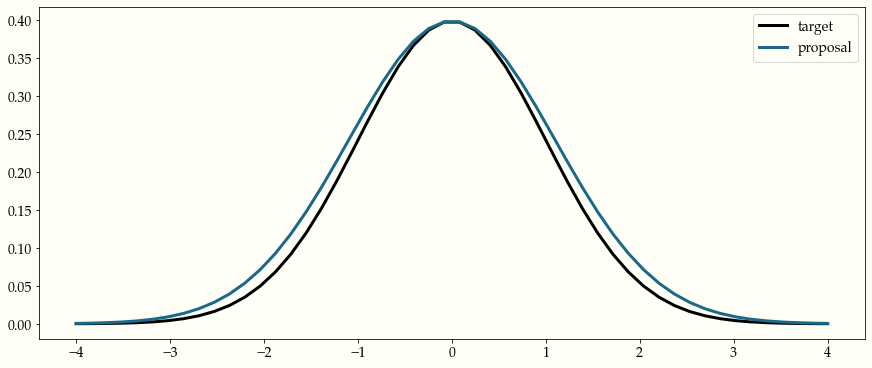

In [13]:
x = np.linspace(-4, 4)
pdf_target = st.norm(0, 1).pdf
pdf_prop = st.norm(0, 1.1).pdf
y_target = pdf_target(x)
y_prop = pdf_prop(x)

k = pdf_target(0) / pdf_prop(0)

plt.plot(x, y_target, label='target');
plt.plot(x, k * y_prop, label='proposal');
plt.legend();

In [14]:
####################
def run_experiment(dims, trials=1_000):
    pdf = st.multivariate_normal(mean=np.zeros(dims), 
                                 cov=np.eye(dims)).pdf
    prop = st.multivariate_normal(mean=np.zeros(dims), 
                                  cov=1.1 * np.eye(dims))
    
    k = pdf(0) / prop.pdf(0)

    samples = prop.rvs(trials)
    sample_pdfs = prop.pdf(samples)
    u = np.random.uniform(low=0, high=k * sample_pdfs)
    
    accept = pdf(samples) > u
    return accept.mean()
####################

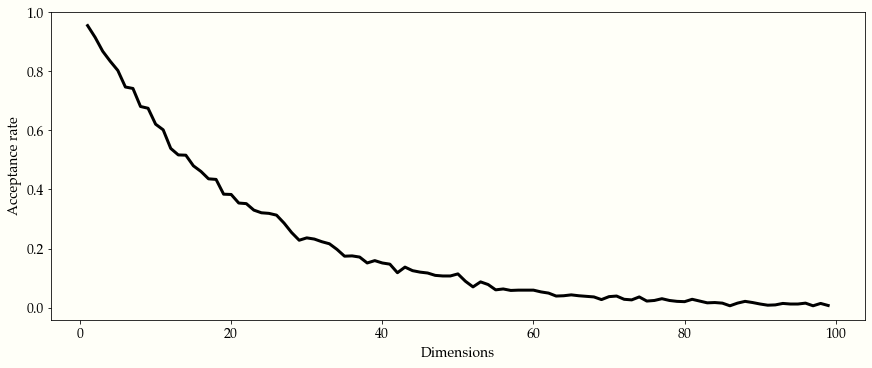

In [15]:
dims = range(1, 100)
accept_rate = [run_experiment(x) for x in dims]
plt.plot(dims, accept_rate)
plt.xlabel('Dimensions'); plt.ylabel('Acceptance rate');

As you can see, this sampler fails badly in higher dimensions as we barely accept any samples.

This is because in higher dimensions our intuitions about what distributions look like go out the window. It is tempting to think of a 1D, 2D, or 3D Gaussian which has most of the probability mass near its center and move that intuition to higher dimensions. However, that is not what is happening. Instead, most of the probability mass goes towards the edge, so the best way to think about high-dimensional distributions is as a donut!

## Importance sampling is useful but we won't cover it!

It produces _weighted_ samples, so that the output is samples and weights. See 11.1.4 in Bishop's "Pattern Recognition and Machine Learning".

## MCMC sampling with the Metropolis algorithm

All these samplers fall short of what we actually need. One obvious issue with the rejection sampler is that we need an enveloping distribution that covers the whole posterior. But for complex models we might have no idea where the probability mass hides.

In addition, this sampler does not scale to higher dimensions, as we've seen.

These previous samplers were Monte Carlo methods, which means they integrated by drawing random samples from the target distribution.

Now we will learn about the actual work-horse of Bayesian statistics: Markov chain Monte Carlo.

We are still generating samples (Monte Carlo) but the way we are generating them is via a Markov chain. Intuitively, what this means is that the sample $i$ we draw will depend on the previous sample $i-1$ we drew.

The Metropolis algorithm which we will cover next is the easiest algorithm of this class. The beauty of this algorithm is that it is very easy to implement, as we will see, and also scales well to higher dimensions. It also works across a very wide class of models. It's thus no surprise that it has been the work-horse of most probabilistic programming languages up until a few years ago when gradient-based samplers became general enough to replace them.

### Let's build a Metropolis sampler

As a deviation to the previous math-first explanations, here we will provide a code-first explanation.

Lets generate some data: 20 points from a normal centered around zero. Our goal will be to estimate the posterior of the mean `mu` (we'll assume that we know the standard deviation to be 1).

In [16]:
data = np.random.randn(20)

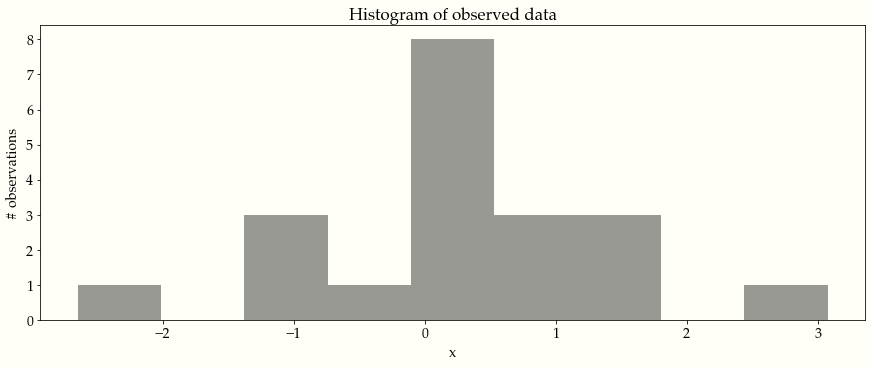

In [17]:
ax = plt.subplot()
sns.distplot(data, kde=False, ax=ax)
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations');

Next, we have to define our model. In this simple case, we will assume that this data is normal distributed, i.e. the likelihood of the model is normal. As you know, a normal distribution has two parameters -- mean $\mu$ and standard deviation $\sigma$. For simplicity, we'll assume we know that $\sigma = 1$ and we'll want to infer the posterior for $\mu$. For each parameter we want to infer, we have to chose a prior. For simplicity, lets also assume  a Normal distribution as a prior for $\mu$. Thus, in stats speak our model is:

$$\theta = \mu \\
P(\theta) = \text{Normal}(0, 1)\\
P(x|\theta) = \text{Normal}(x | \theta, 1)$$

What is convenient, is that for this model, we actually can compute the posterior analytically. That's because for a normal likelihood with known standard deviation, the normal prior for `mu` is [**conjugate**](https://en.wikipedia.org/wiki/Conjugate_prior) (conjugate here means that our posterior will follow the same distribution as the prior), so we know that our posterior for $\mu$ is also normal. We can easily look up on wikipedia how we can compute the parameters of the posterior. For a mathemtical derivation of this, see [here](https://docs.google.com/viewer?a=v&pid=sites&srcid=ZGVmYXVsdGRvbWFpbnxiYXllc2VjdHxneDplNGY0MDljNDA5MGYxYTM).

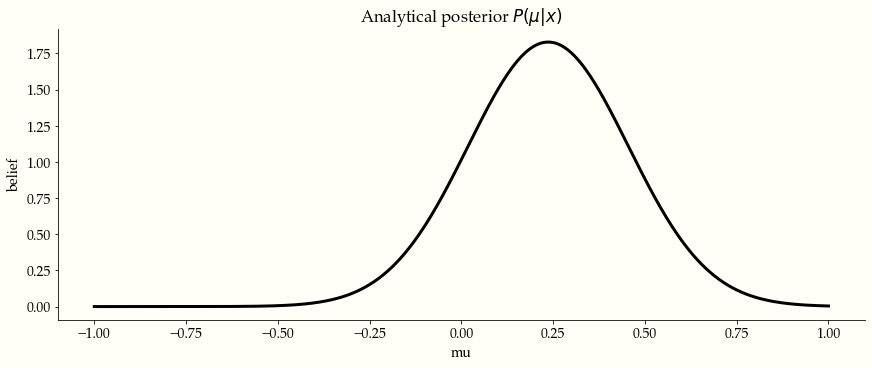

In [18]:
from scipy.stats import norm

def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

ax = plt.subplot()
x = np.linspace(-1, 1, 500)
posterior_analytical = calc_posterior_analytical(data, x, 0., 1.)
ax.plot(x, posterior_analytical)
ax.set(xlabel='mu', ylabel='belief', title='Analytical posterior $P(\mu | x)$');
sns.despine()

This shows our quantity of interest, the probability of $\mu$'s values after having seen the data, taking our prior information into account. Lets assume, however, that our prior wasn't conjugate and we couldn't solve this by hand which is usually the case.

## Explaining MCMC sampling with code

Now on to the sampling logic. At first, you find starting parameter position (can be randomly chosen), lets fix it arbitrarily to:

```python
mu_current = 3.
```

Then, you propose to move (jump) from that position somewhere else (that's the Markov part). You can be very dumb or very sophisticated about how you come up with that proposal. The Metropolis sampler is very dumb and just takes a sample from a normal distribution (no relationship to the normal we assume for the model) centered around your current `mu` value (i.e. `mu_current`) with a certain standard deviation (`proposal_width`) that will determine how far you propose jumps (here we're use `scipy.stats.norm`):

```python
mu_proposal = norm(mu_current, proposal_width).rvs()
```

Next, you evaluate whether that's a good place to jump to or not. If the resulting normal distribution with that proposed `mu` explaines the data better than your old `mu`, you'll definitely want to go there. What does "explains the data better" mean? We quantify fit by computing the probability of the data, given the likelihood (normal) with the proposed parameter values (proposed `mu` and a fixed `sigma = 1`). This can easily be computed by calculating the probability for each data point using `scipy.stats.normal(mu, sigma).pdf(data)` and then multiplying the individual probabilities, i.e. compute the likelihood (usually you would use log probabilities but we omit this here):

```python
likelihood_current = norm(mu_current, 1).pdf(data).prod()
likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
# Compute prior probability of current and proposed mu        
prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)

# Nominator of Bayes formula
p_current = likelihood_current * prior_current
p_proposal = likelihood_proposal * prior_proposal

```

Up until now, we essentially have a hill-climbing algorithm that would just propose movements into random directions and only accept a jump if the `mu_proposal` has higher likelihood than `mu_current`. Eventually we'll get to `mu = 0` (or close to it) from where no more moves will be possible. However, we want to get a posterior so we'll also have to sometimes accept moves into the other direction. The key trick is by dividing the two probabilities,

```python
p_accept = p_proposal / p_current
```

we get an acceptance probability. You can already see that if `p_proposal` is larger, that probability will be `> 1` and we'll definitely accept. However, if `p_current` is larger, say twice as large, there'll be a 50% chance of moving there:

```python
accept = np.random.rand() < p_accept

if accept:
    # Update position
    cur_pos = proposal

```

This simple procedure gives us samples from the posterior.

### Why does this make sense?
Taking a step back, note that the above acceptance ratio is the reason this whole thing works out and we get around the integration. We can show this by computing the acceptance ratio over the normalized posterior and seeing how it's equivalent to the acceptance ratio of the unnormalized posterior (lets say $\mu_0$ is our current position, and $\mu$ is our proposal):

$$ \frac{\frac{P(x|\mu) P(\mu)}{P(x)}}{\frac{P(x|\mu_0) P(\mu_0)}{P(x)}} = \frac{P(x|\mu) P(\mu)}{P(x|\mu_0) P(\mu_0)}$$

In words, dividing the posterior of proposed parameter setting by the posterior of the current parameter setting, $P(x)$ -- that nasty quantity we can't compute -- gets canceled out. So you can intuit that we're actually dividing the full posterior at one position by the full posterior at another position (no magic here). That way, we are visiting regions of high posterior probability *relatively* more often than those of low posterior probability.

### Putting it all together

In [19]:
def sampler(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept
        
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return np.array(posterior)

# Function to display
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    x = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm(mu_prior_mu, mu_prior_sd).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))
    
    # Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm(loc=mu_proposal, scale=1).pdf(x)
    sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
    ax2.plot(x, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))
    
    # Posterior
    posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd)
    ax3.plot(x, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    #x3.set(title=r'prior x likelihood $\propto$ posterior')
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))
    
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    #plt.tight_layout()
    #plt.legend()

## Visualizing MCMC

To visualize the sampling, we'll create plots for some quantities that are computed. Each row below is a single iteration through our Metropolis sampler. 

The first columns is our prior distribution -- what our belief about $\mu$ is before seeing the data. You can see how the distribution is static and we only plug in our $\mu$ proposals. The vertical lines represent our current $\mu$ in blue and our proposed $\mu$ in either red or green (rejected or accepted, respectively). 

The 2nd column is our likelihood and what we are using to evaluate how good our model explains the data. You can see that the likelihood function changes in response to the proposed $\mu$. The blue histogram which is our data. The solid line in green or red is the likelihood with the currently proposed `mu`. Intuitively, the more overlap there is between likelihood and data, the better the model explains the data and the higher the resulting probability will be. The dotted line of the same color is the proposed `mu` and the dotted blue line is the current `mu`.

The 3rd column is our posterior distribution. Here I am displaying the normalized posterior but as we found out above, we can just multiply the prior value for the current and proposed $\mu$'s by the likelihood value for the two $\mu$'s to get the unnormalized posterior values (which we use for the actual computation), and divide one by the other to get our acceptance probability.

The 4th column is our trace (i.e. the posterior samples of $\mu$ we're generating) where we store each sample irrespective of whether it was accepted or rejected (in which case the line just stays constant).

Note that we always move to relatively more likely $\mu$ values (in terms of their posterior density), but only sometimes to relatively less likely $\mu$ values, as can be seen in iteration 14 (the iteration number can be found at the top center of each row).

/Users/twiecki/miniconda3/envs/bayes_course/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/twiecki/miniconda3/envs/bayes_course/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/twiecki/miniconda3/envs/bayes_course/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed an

/Users/twiecki/miniconda3/envs/bayes_course/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/twiecki/miniconda3/envs/bayes_course/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/twiecki/miniconda3/envs/bayes_course/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed an

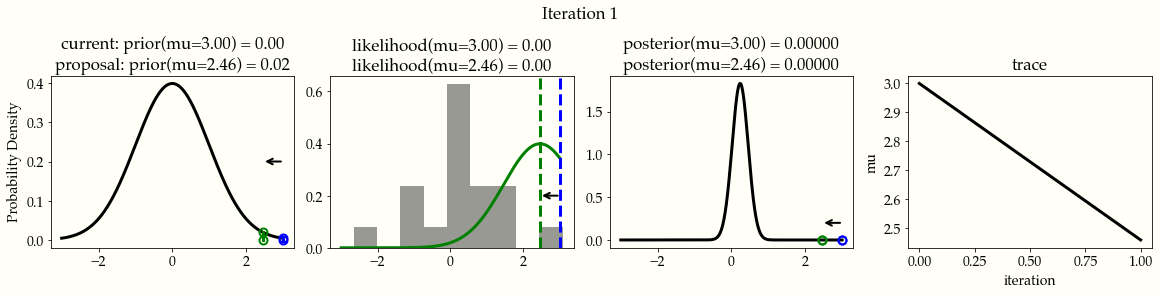

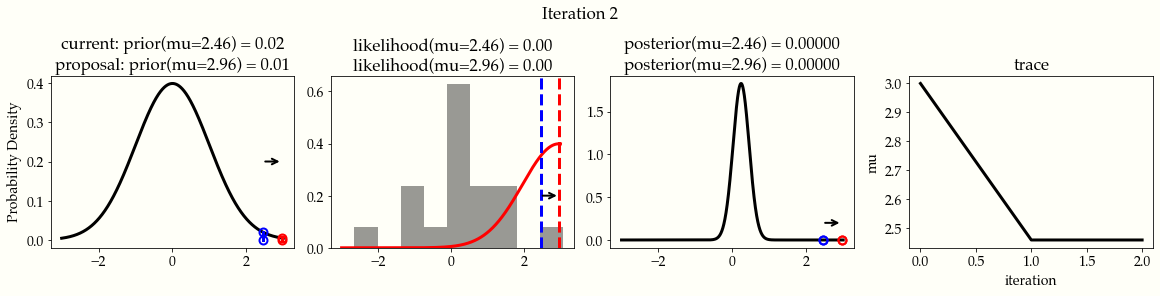

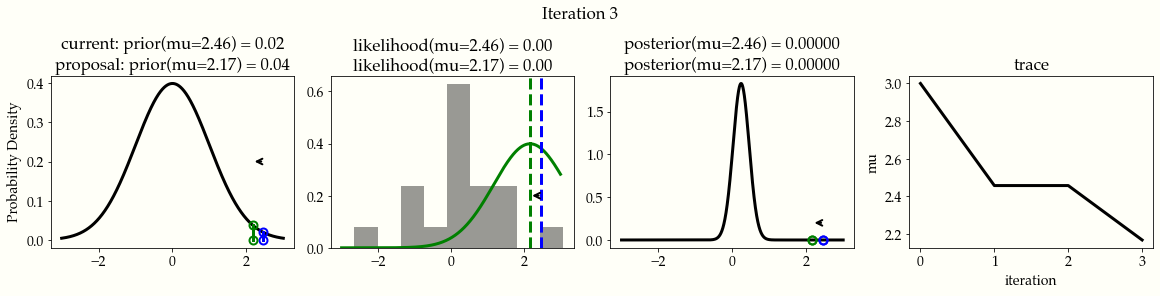

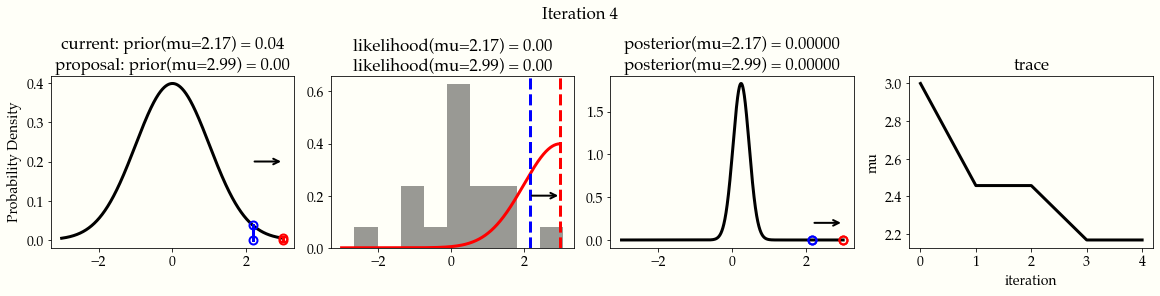

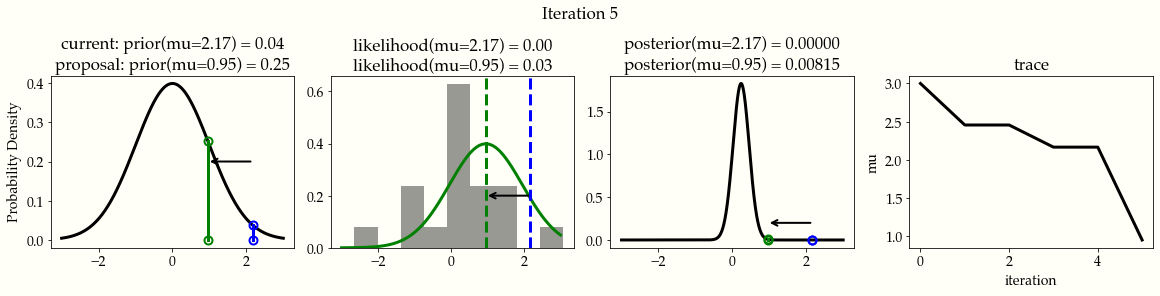

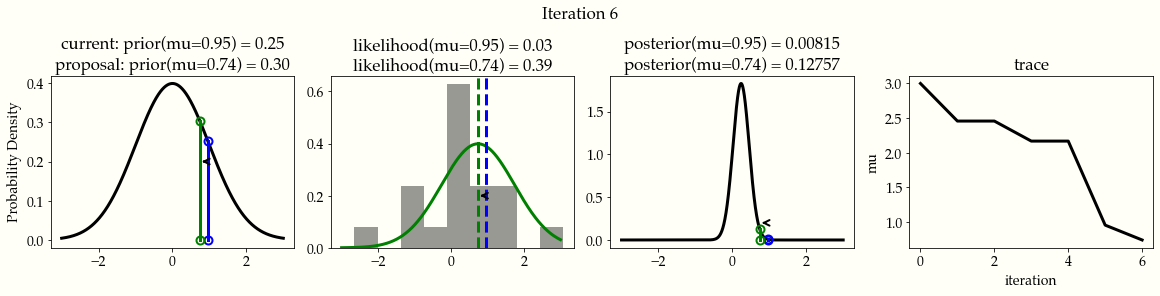

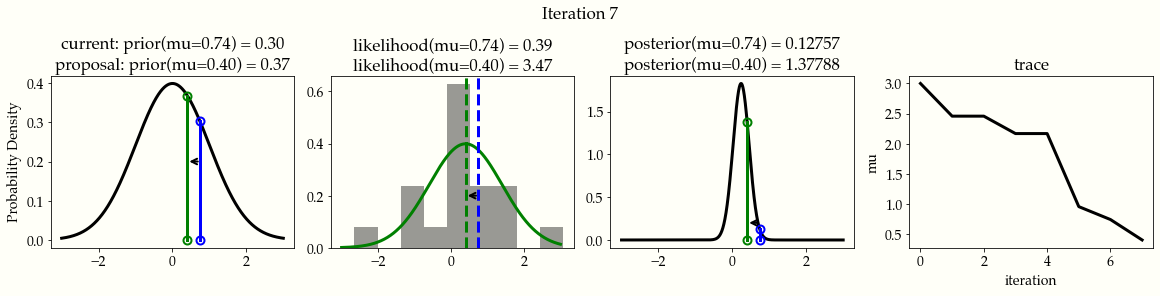

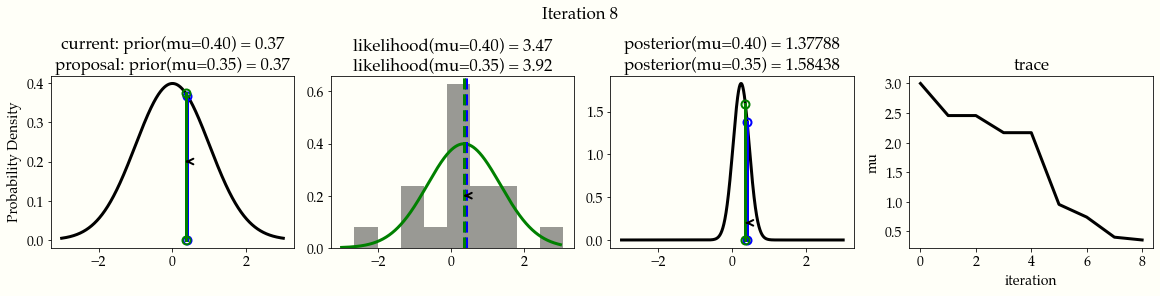

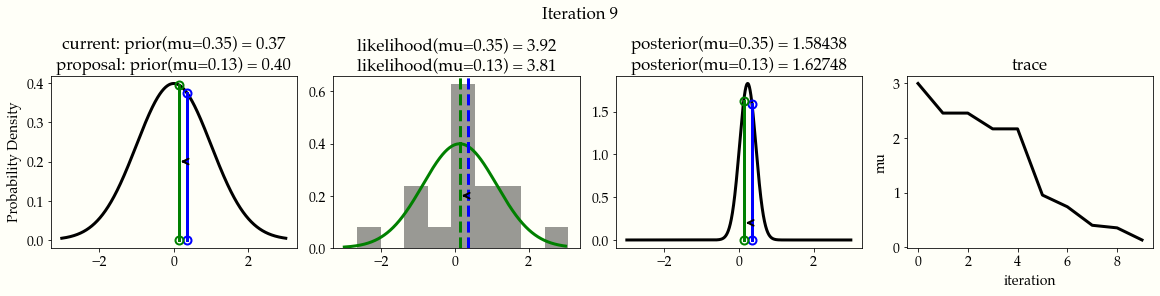

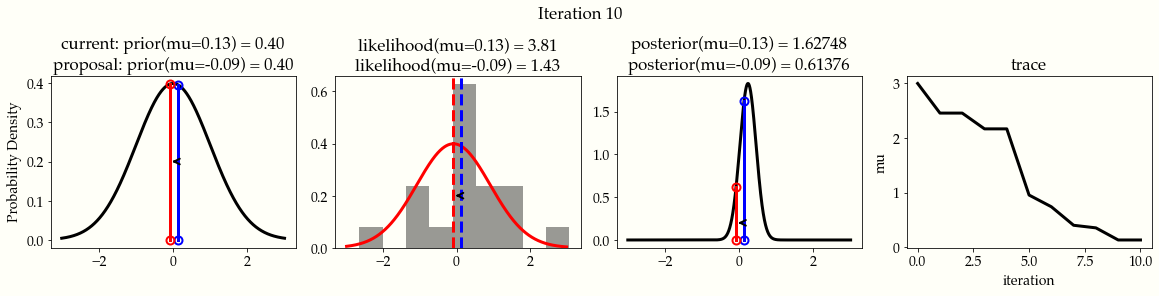

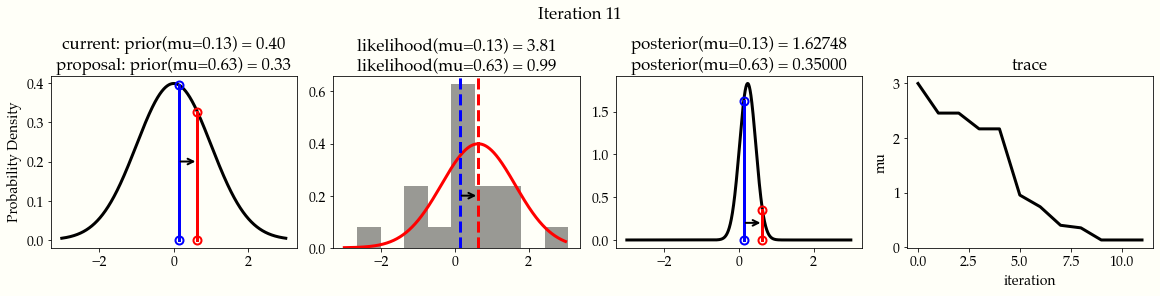

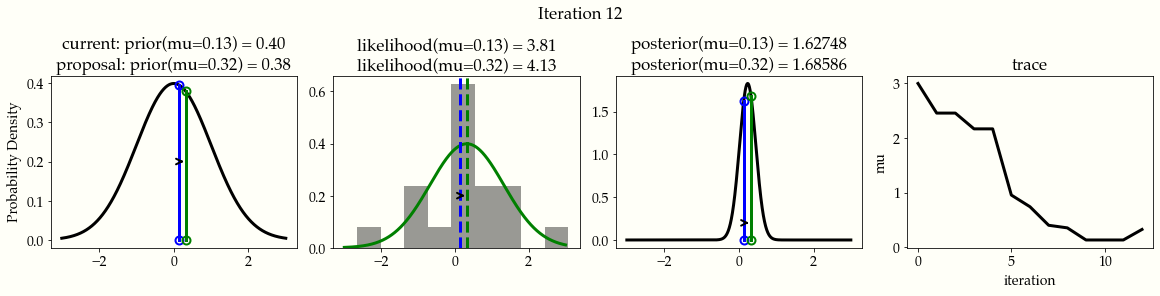

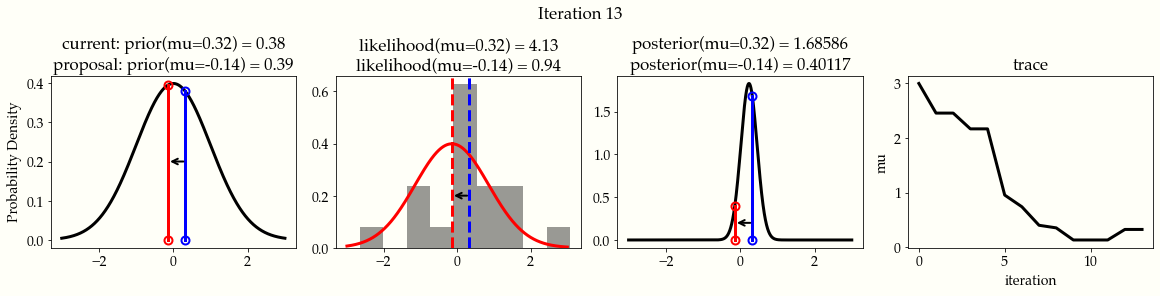

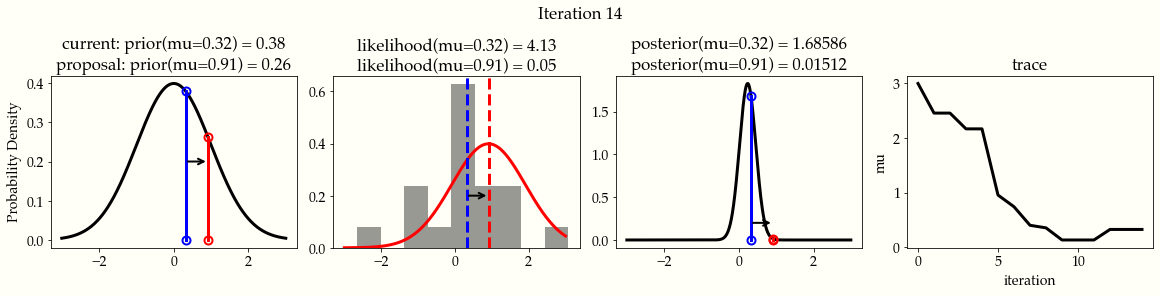

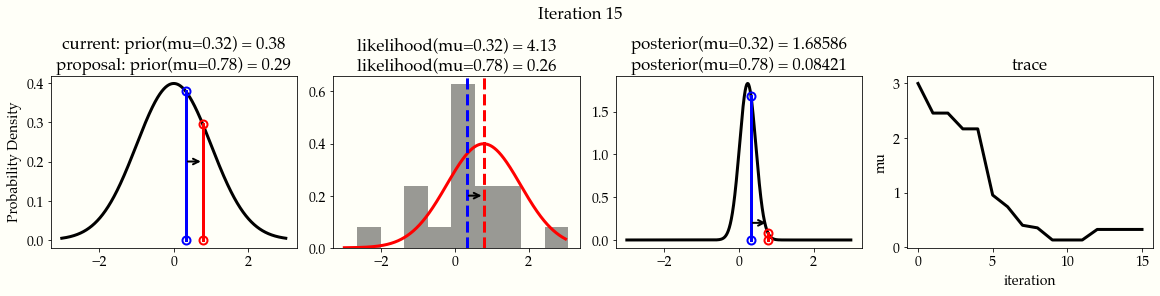

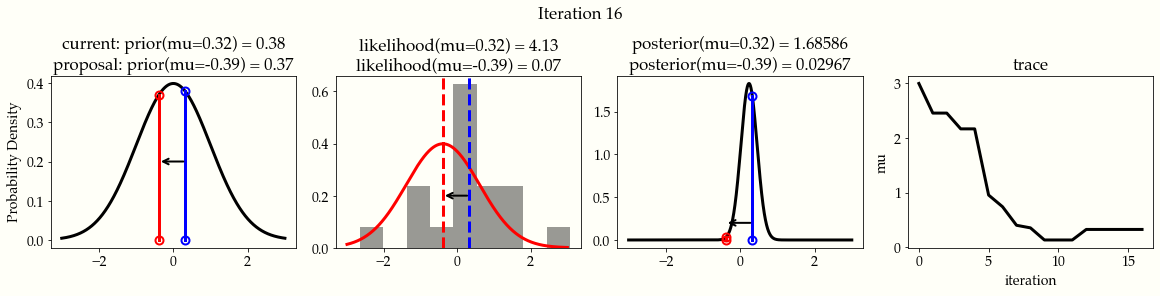

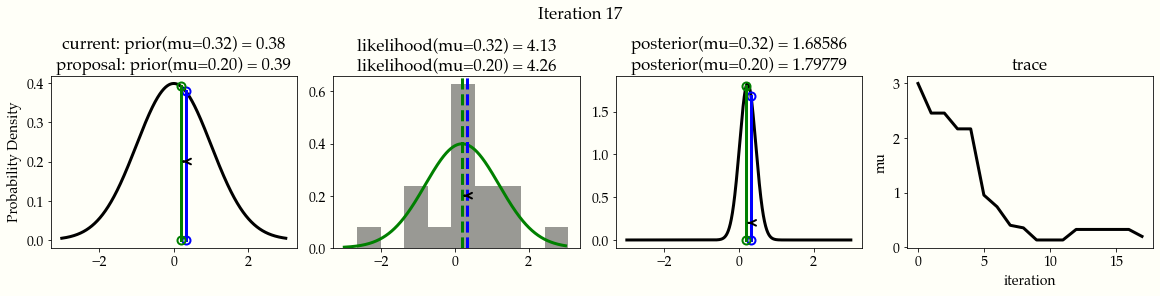

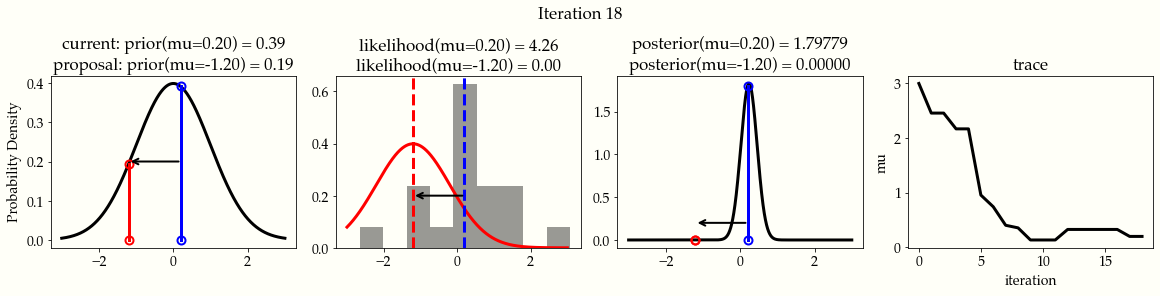

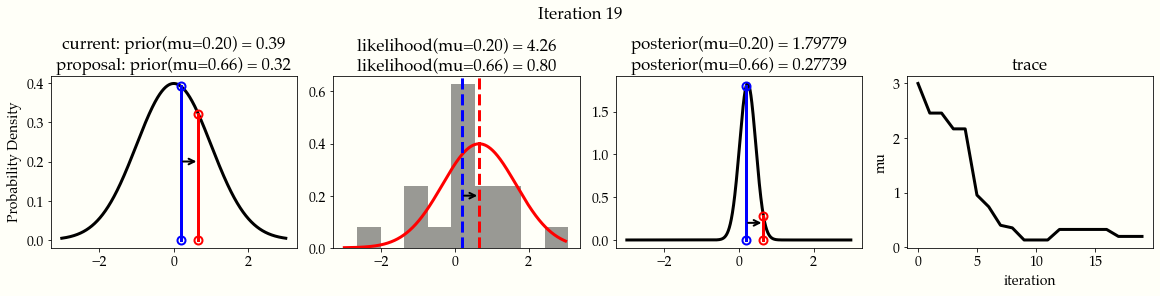

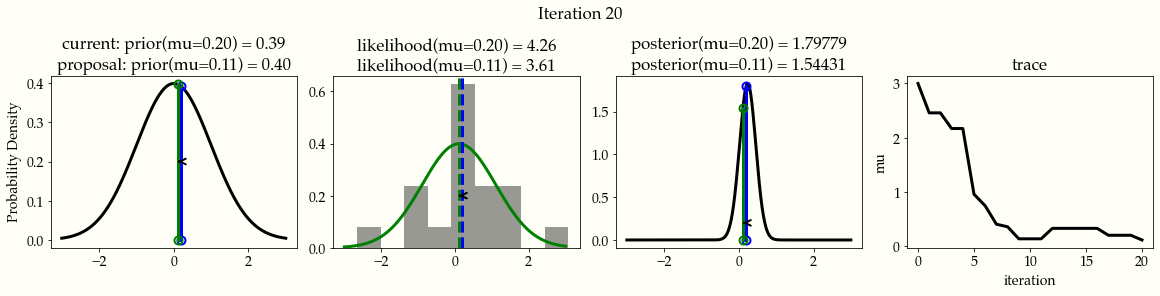

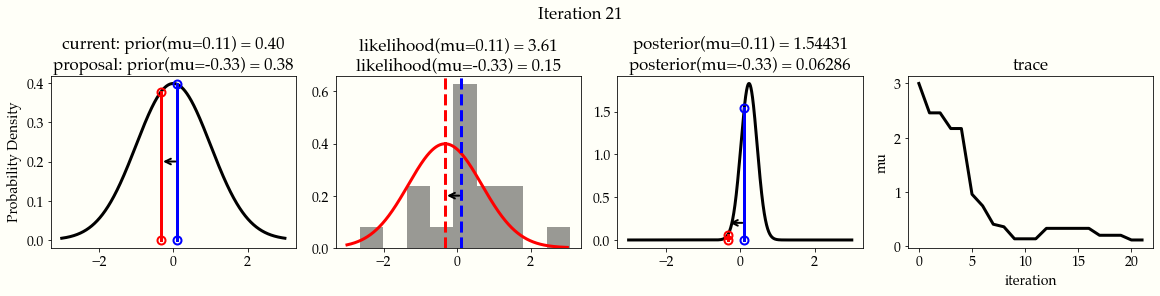

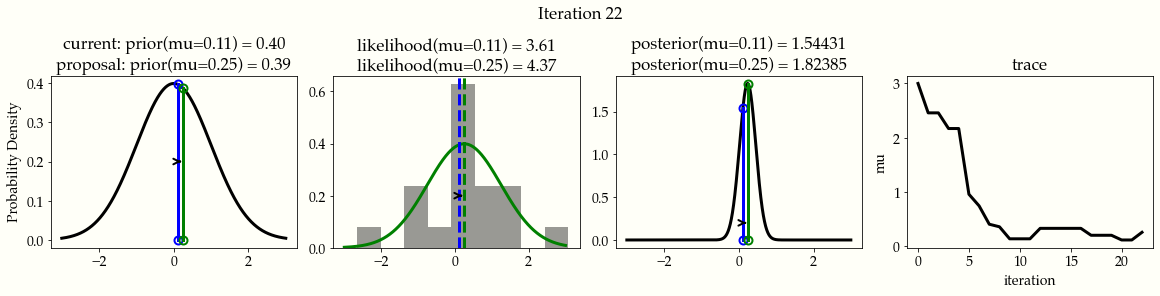

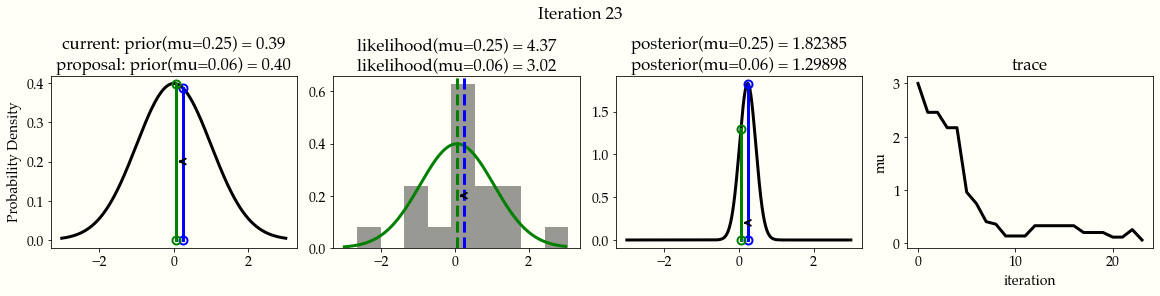

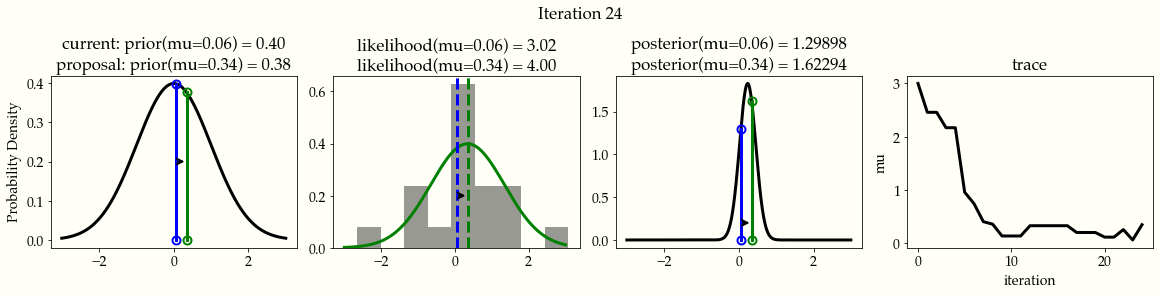

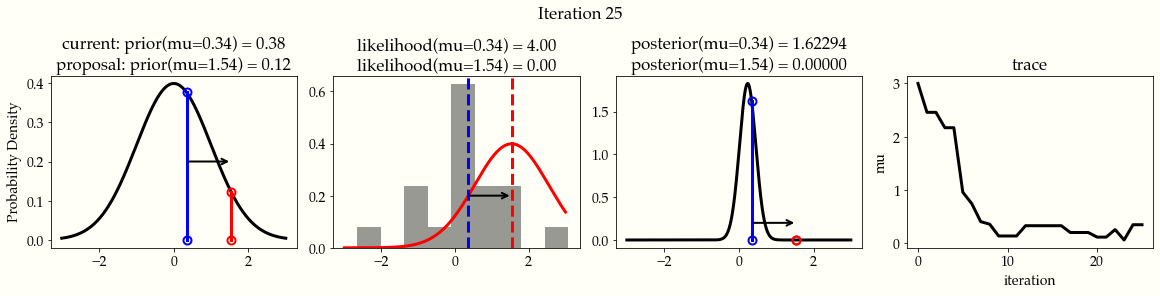

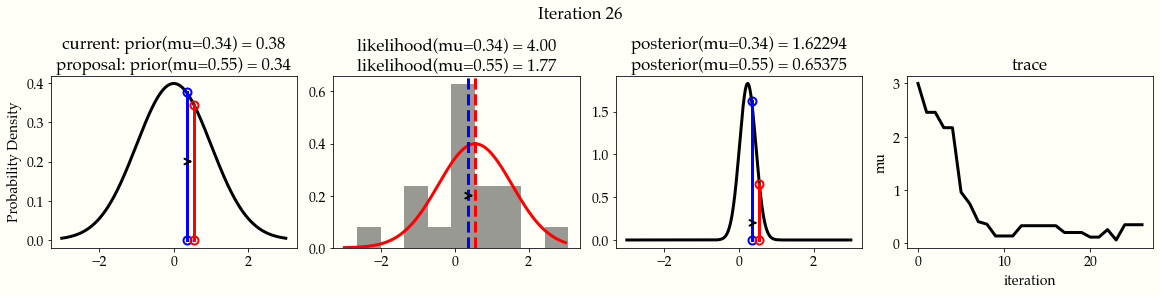

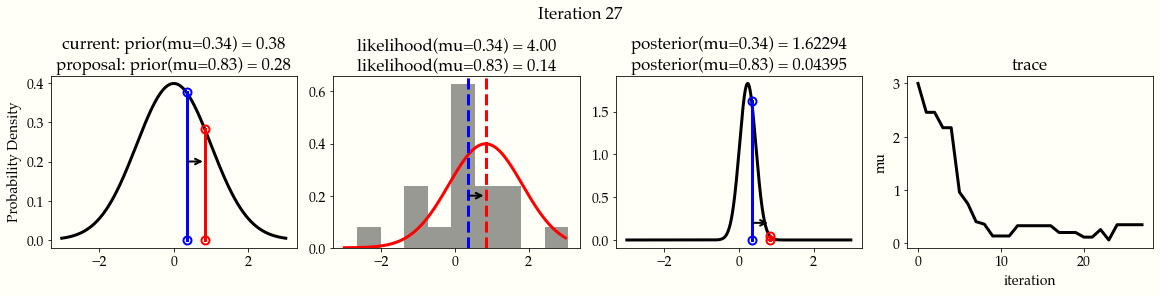

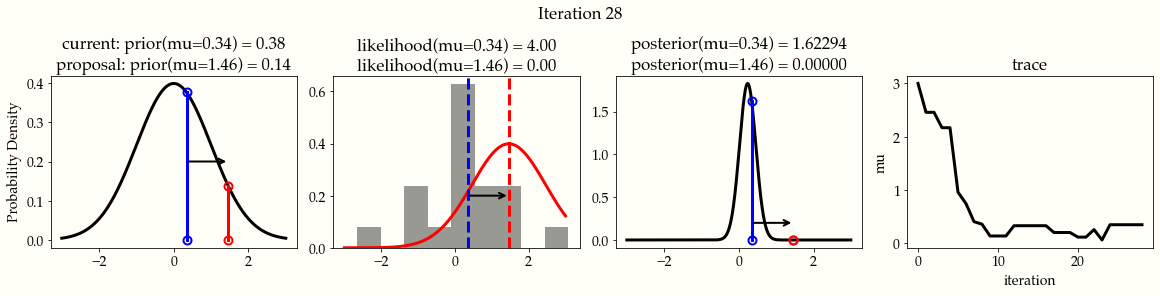

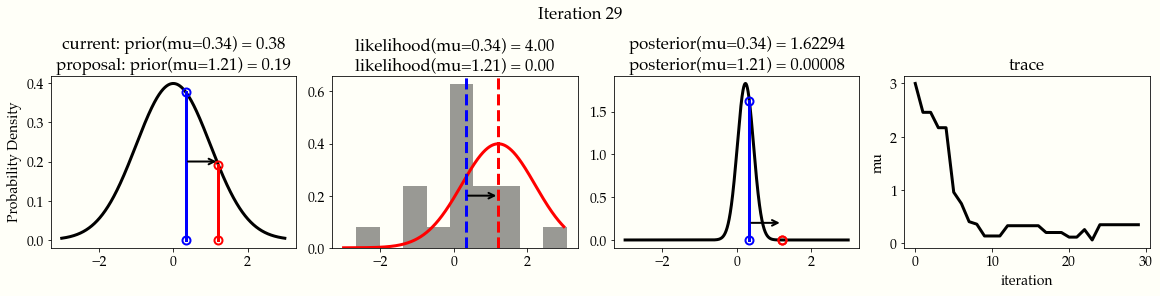

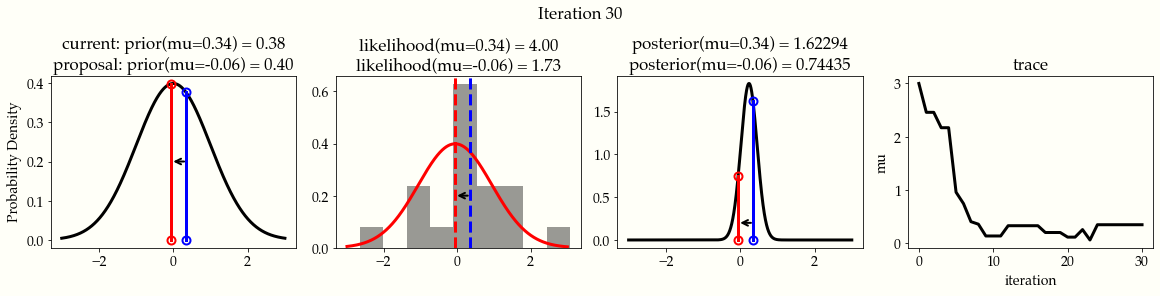

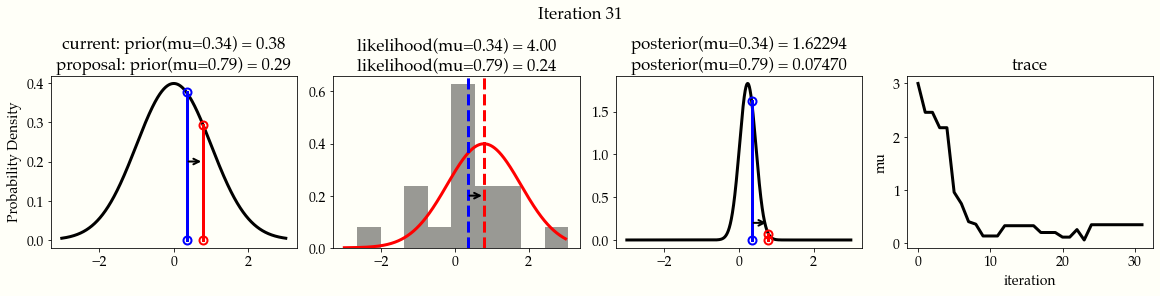

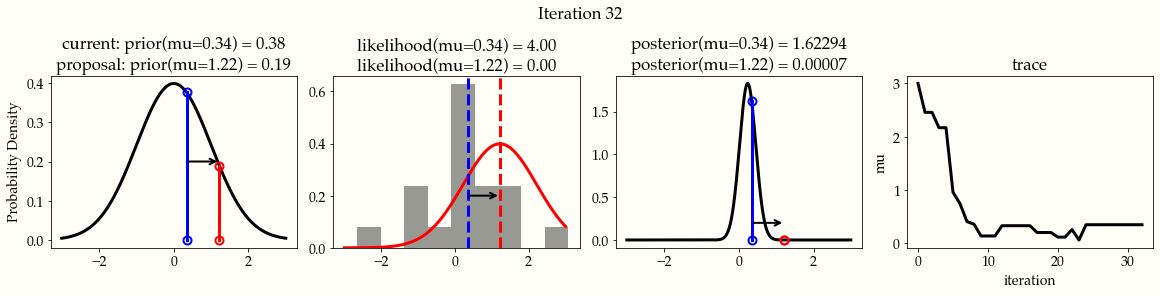

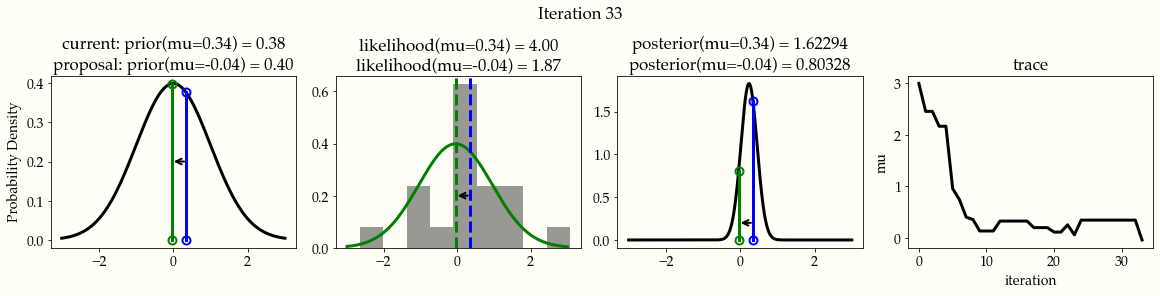

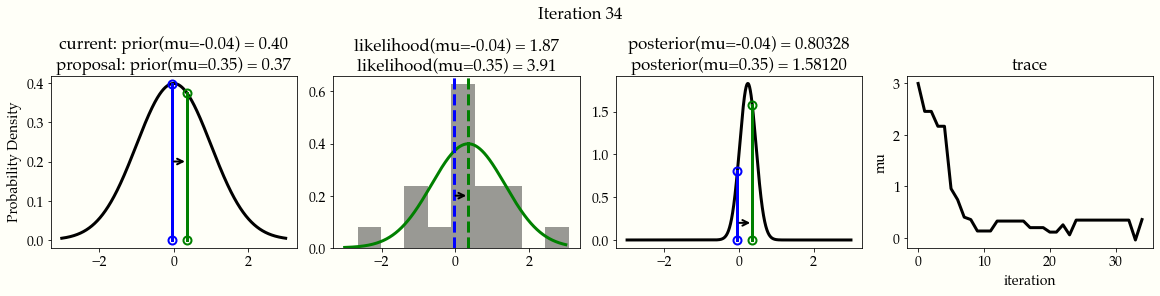

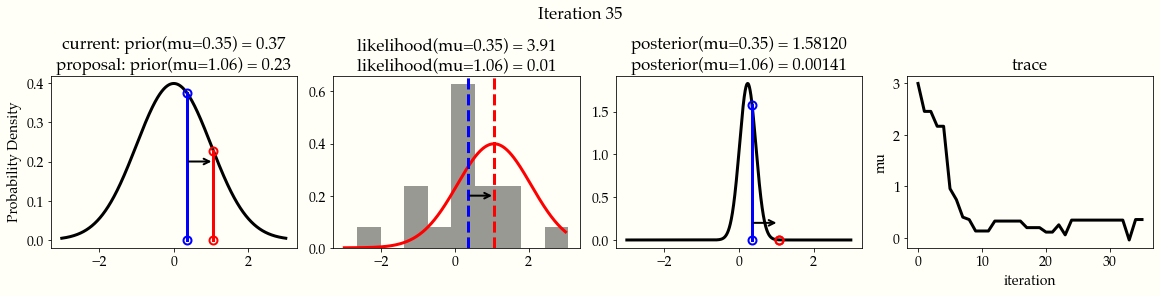

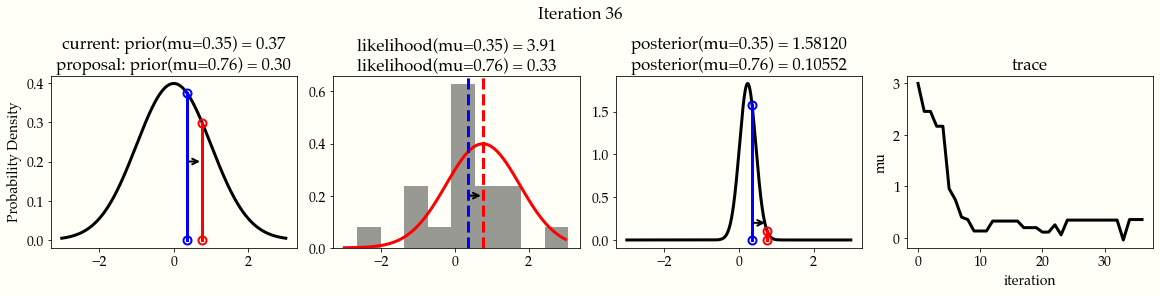

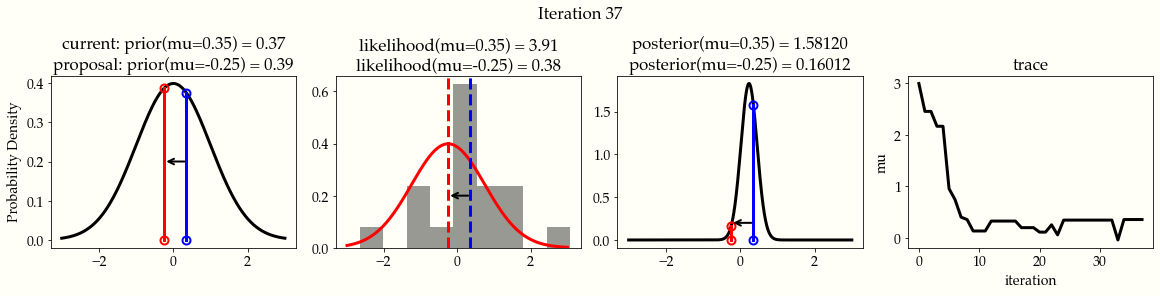

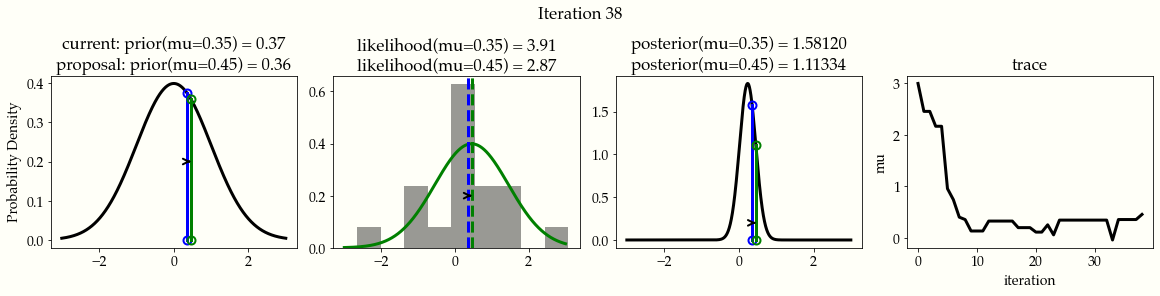

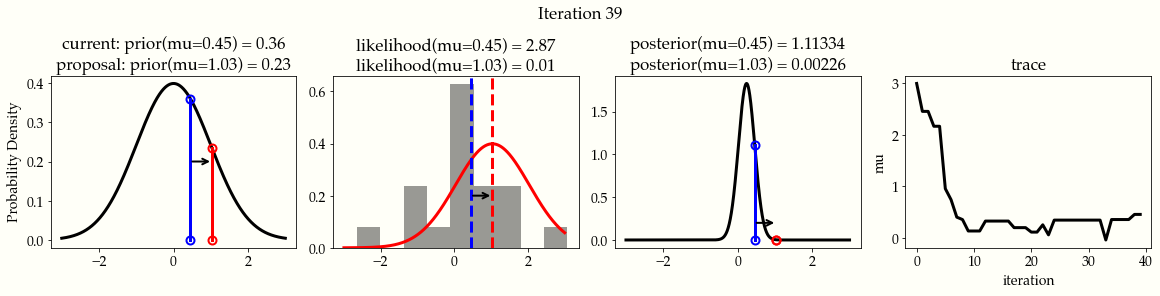

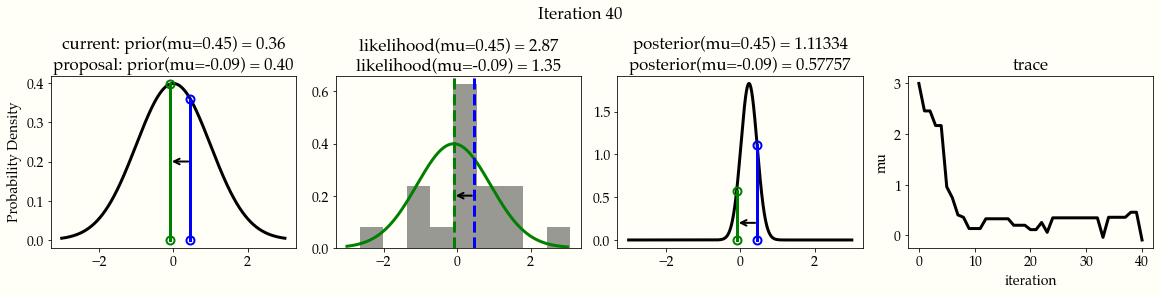

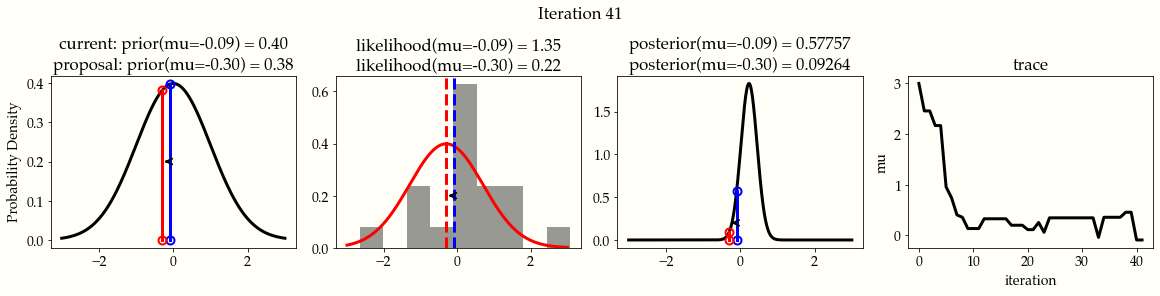

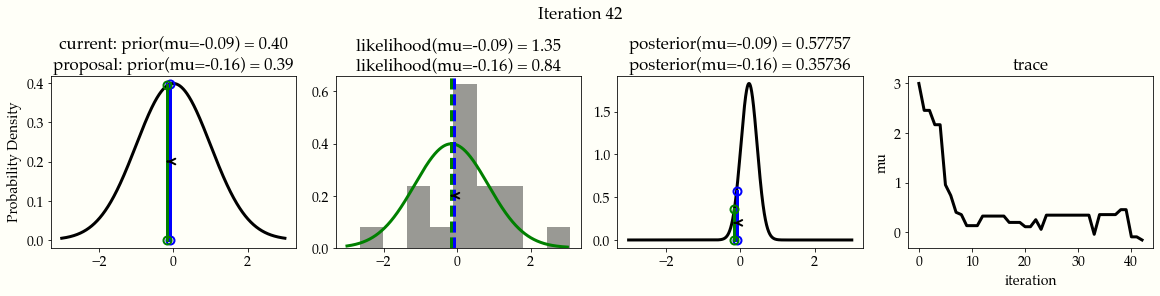

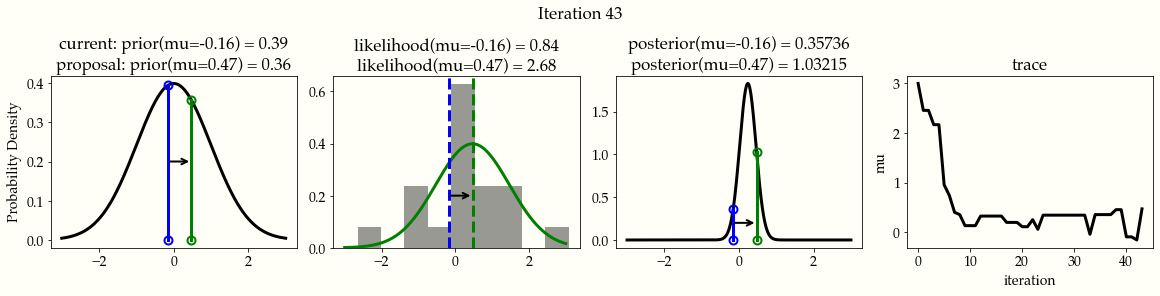

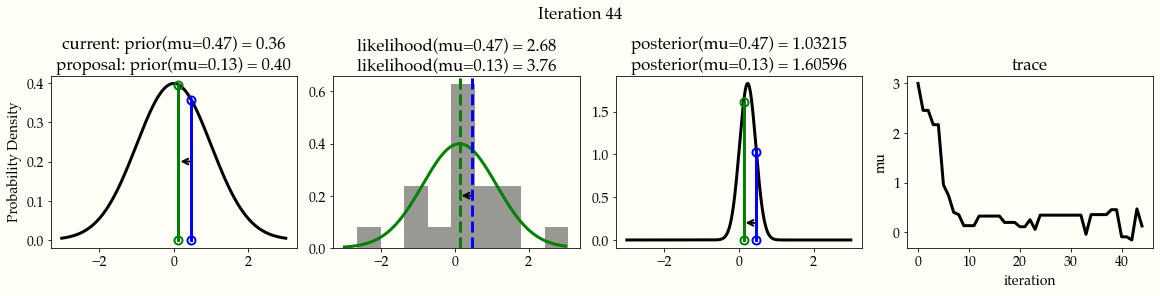

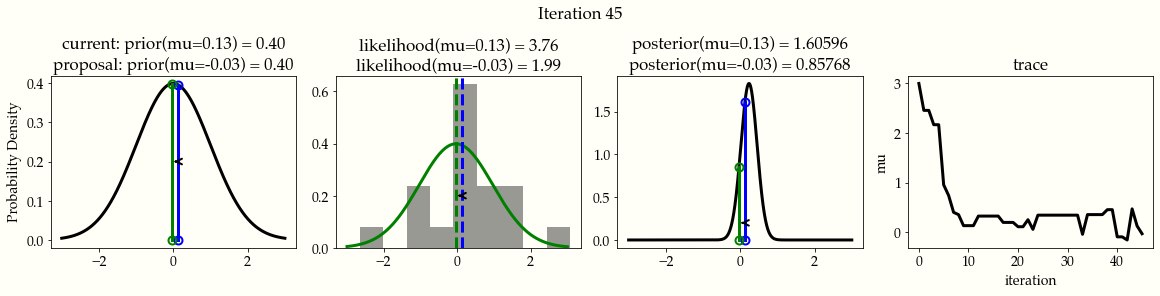

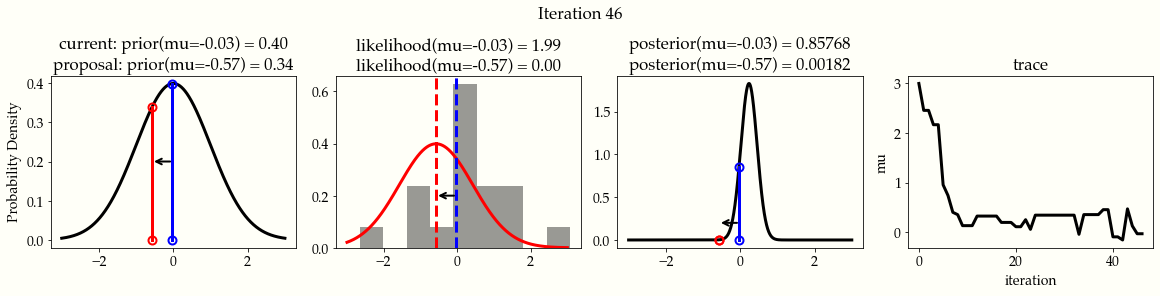

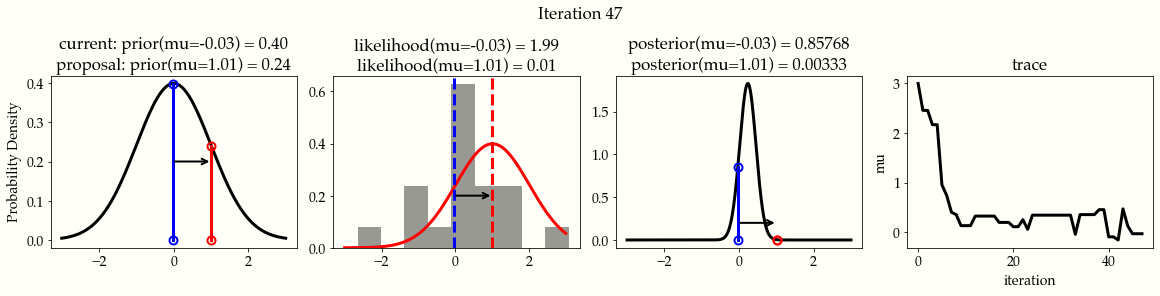

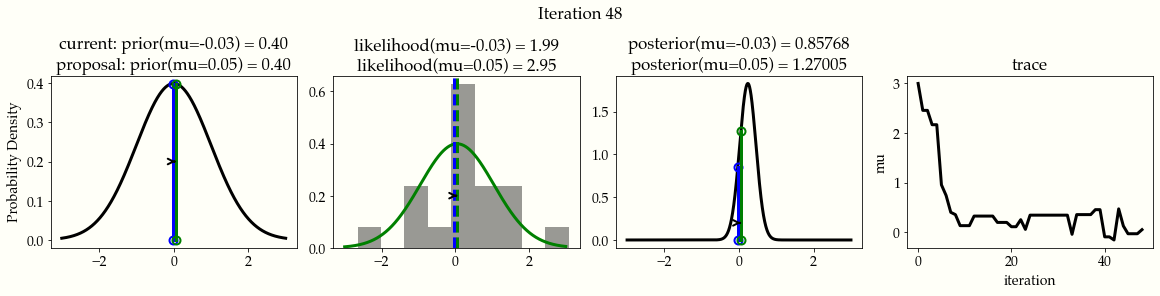

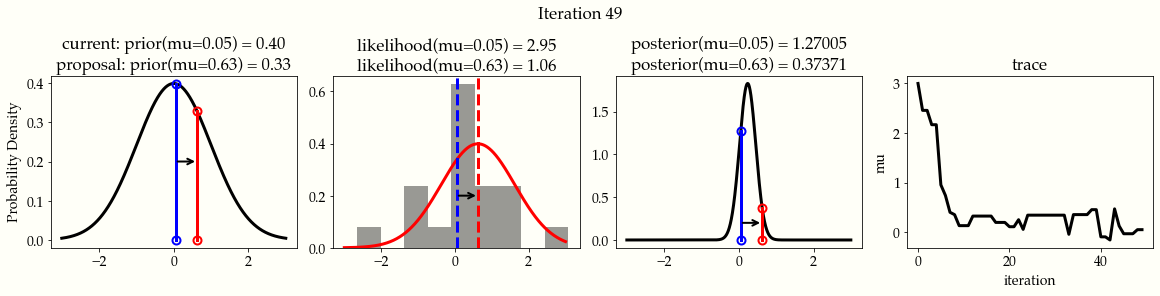

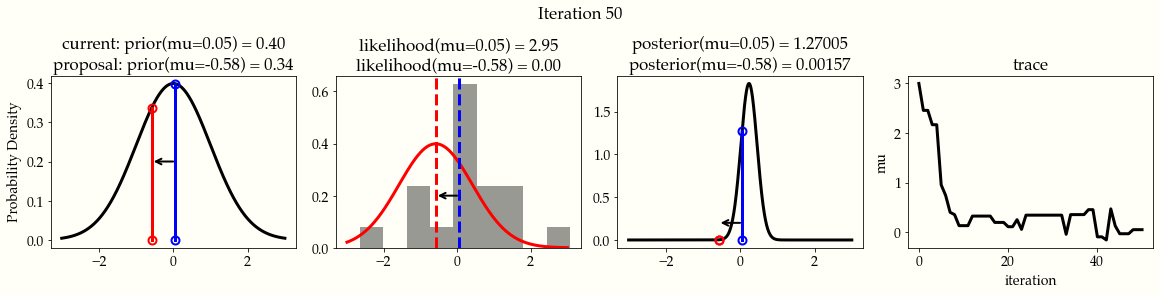

In [20]:
np.random.seed(123)
sampler(data, samples=50, mu_init=3., plot=True);

Now the magic of MCMC is that you just have to do that for a long time, and the samples that are generated in this way come from the posterior distribution of your model. There is a rigorous mathematical proof that guarantees this which I won't go into detail here.

To get a sense of what this produces, lets draw a lot of samples and plot them.

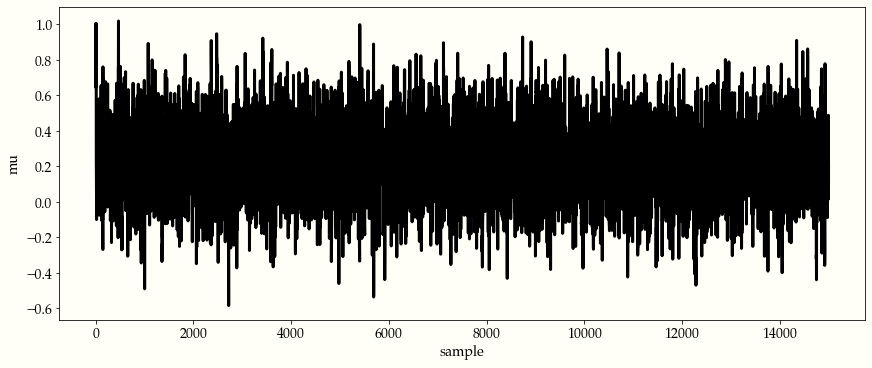

In [21]:
posterior = sampler(data, samples=15000, mu_init=1.)
fig, ax = plt.subplots()
ax.plot(posterior)
_ = ax.set(xlabel='sample', ylabel='mu');

This is usually called the trace. To now get an approximation of the posterior (the reason why we're doing all this), we simply take the histogram of this trace. It's important to keep in mind that although this looks similar to the data we sampled above to fit the model, the two are completely separate. The below plot represents our **belief** in `mu`. In this case it just happens to also be normal but for a different model, it could have a completely different shape than the likelihood or prior.

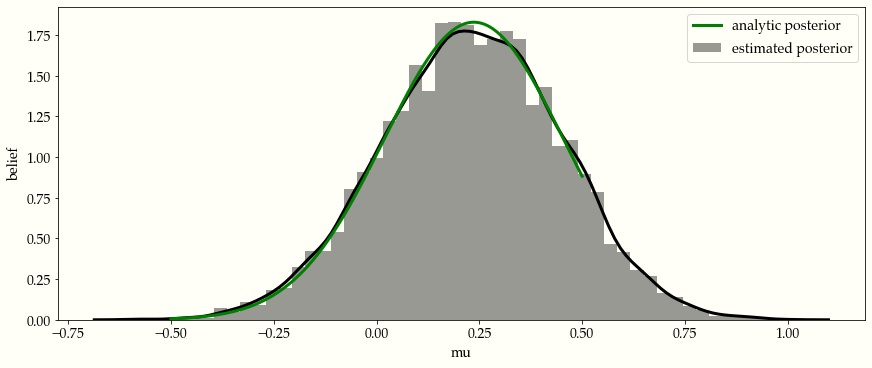

In [22]:
ax = plt.subplot()

sns.distplot(posterior[500:], ax=ax, label='estimated posterior')
x = np.linspace(-.5, .5, 500)
post = calc_posterior_analytical(data, x, 0, 1)
ax.plot(x, post, 'g', label='analytic posterior')
_ = ax.set(xlabel='mu', ylabel='belief');
ax.legend();

As you can see, by following the above procedure, we get samples from the same distribution as what we derived analytically.

## How far to jump, setting the proposal width

Above we set the proposal width to `0.5`. That turned out to be a pretty good value. In general you don't want the width to be too narrow because your sampling will be inefficient as it takes a long time to explore the whole parameter space and shows the typical random-walk behavior:

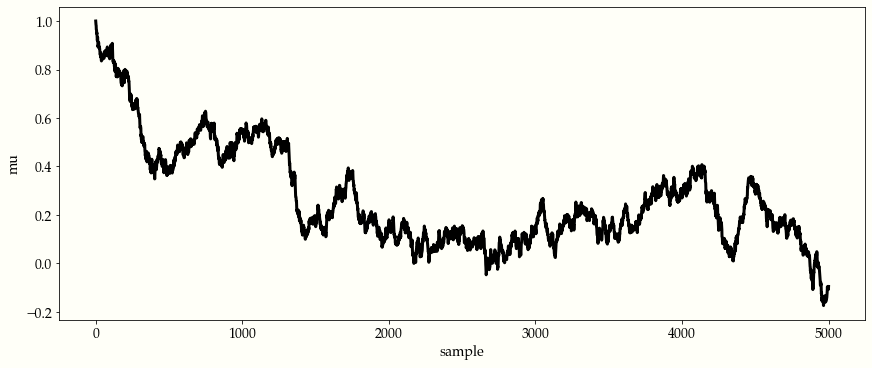

In [23]:
posterior_small = sampler(data, samples=5000, mu_init=1., 
                          proposal_width=.01)
fig, ax = plt.subplots()
ax.plot(posterior_small);
_ = ax.set(xlabel='sample', ylabel='mu');

But you also don't want it to be so large that you never accept a jump:

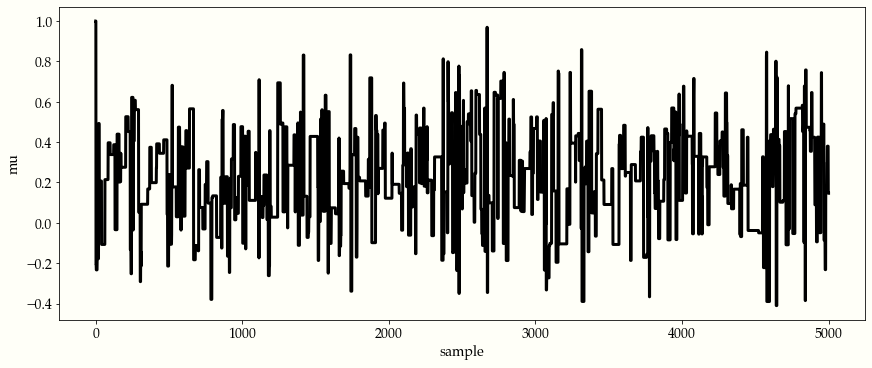

In [24]:
posterior_large = sampler(data, samples=5000, mu_init=1., 
                          proposal_width=3.)
fig, ax = plt.subplots()
ax.plot(posterior_large); plt.xlabel('sample'); plt.ylabel('mu');
_ = ax.set(xlabel='sample', ylabel='mu');

Note, however, that we are still sampling from our target posterior distribution here as guaranteed by the mathematical proof, just less efficiently:

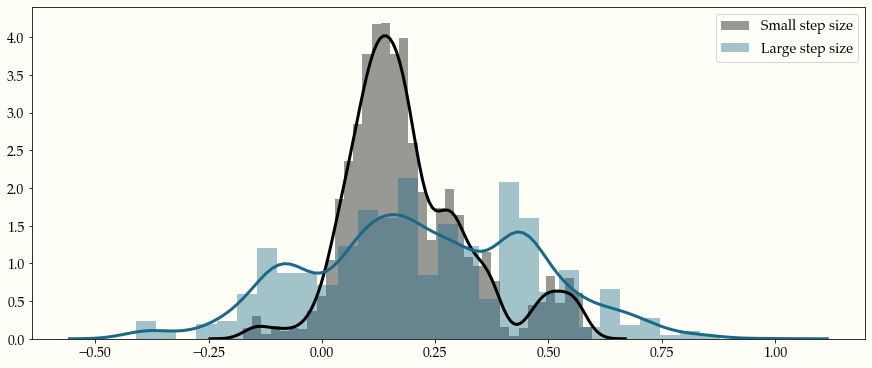

In [25]:
sns.distplot(posterior_small[1000:], label='Small step size')
sns.distplot(posterior_large[1000:], label='Large step size');
_ = plt.legend();

With more samples this will eventually look like the true posterior. The key is that we want our samples to be independent of each other which cleary isn't the case here. Thus, one common metric to evaluate the efficiency of our sampler is the autocorrelation -- i.e. how correlated a sample `i` is to sample `i-1`, `i-2`, etc:

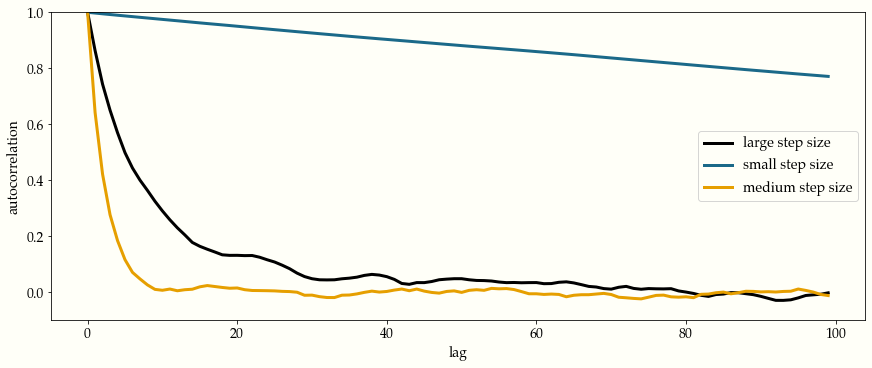

In [31]:
from arviz.stats import autocorr
fig, ax = plt.subplots()
ax.plot(autocorr(posterior_large)[:100], label='large step size')
ax.plot(autocorr(posterior_small)[:100], label='small step size')
ax.plot(autocorr(posterior)[:100], label='medium step size')
ax.legend(loc=0)
_ = ax.set(xlabel='lag', ylabel='autocorrelation', ylim=(-.1, 1))

Obviously we want to have a smart way of figuring out the right step width automatically. One common method is to keep adjusting the proposal width so that roughly 50% proposals are rejected.

## Bonus homework

Come up with an algorithm to adjust the proposal width to give a mean acceptance rate of around 50%.

## Extending to more complex models

Now you can easily imagine that we could also add a `sigma` parameter for the standard-deviation and follow the same procedure for this second parameter. In that case, we would be generating proposals for `mu` *and* `sigma` but the algorithm logic would be nearly identical. Or, we could have data from a very different distribution like a Binomial and still use the same algorithm and get the correct posterior. That's pretty cool and a huge benefit of probabilistic programming: Just define the model you want and let MCMC take care of the inference.

For example, the below model can be written in `PyMC3` quite easily. Below we also use the Metropolis sampler (which automatically tunes the proposal width) and see that we get identical results. Feel free to play around with this and change the distributions. For more information, as well as more complex examples, see the [PyMC3 documentation](http://pymc-devs.github.io/pymc3/getting_started/).

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [mu]


Sampling 2 chains for 1_000 tune and 15_000 draw iterations (2_000 + 30_000 draws total) took 18 seconds.
The number of effective samples is smaller than 25% for some parameters.


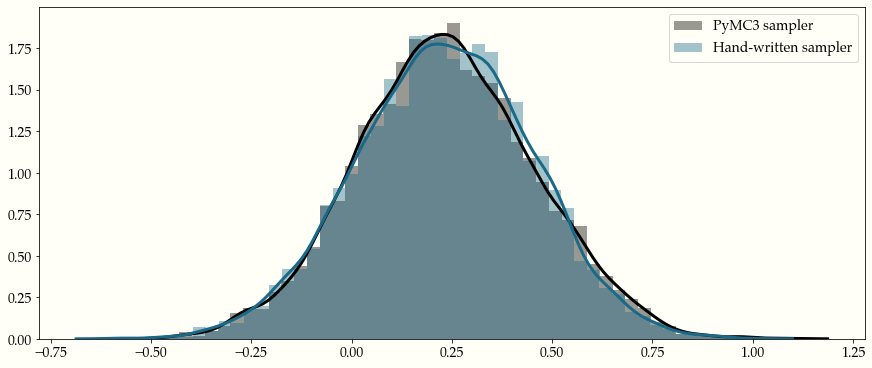

In [40]:
import pymc3 as pm

with pm.Model() as model:
    mu = pm.Normal('mu', 0, 1)
    sigma = 1.
    returns = pm.Normal('returns', mu=mu, 
                        sigma=sigma, observed=data)
    
    step = pm.Metropolis()
    trace = pm.sample(15000, step)
    
sns.distplot(trace[2000:]['mu'], label='PyMC3 sampler');
sns.distplot(posterior[500:], label='Hand-written sampler');
plt.legend();

Hopefully this gives an intuitive understanding of the famous trace plot:

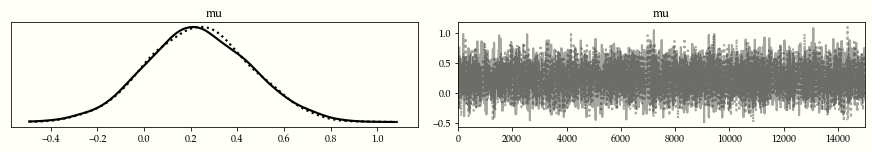

In [41]:
with model:
    pm.traceplot(trace);

## Gibbs Sampling

If you can sample from all the marginal distributions, you can implement a sampler pretty efficiently just using those.

The general idea is to:

1. Initialize $\theta^0 = (\theta_1^0, \theta_2^0, \ldots, \theta_n^0)$, and $j = 0$
2. For each $k = 1, 2, \ldots, n$:
    - Set $\theta_k^j \sim \pi(\theta_k^j | \theta_1^j, \theta_2^j, \ldots, \theta_n^j)$
3. Increment $j$, and repeat as long as desired

This is pretty tricky to automate, since you need to know all of these conditional distributions! That said, this is often seen in science when a sampler is hand-built to do inference with a specific model. In that case, each conditional distribution might be computed by hand.

### Coal mining example
We have a time series of recorded coal mining disasters in the UK from 1851 to 1961.

Occurrences of disasters in the time series is thought to be derived from a Poisson process with a large rate parameter in the early part of the time series, and from one with a smaller rate in the later part. We are interested in locating the change point in the series, which perhaps is related to changes in mining safety regulations.


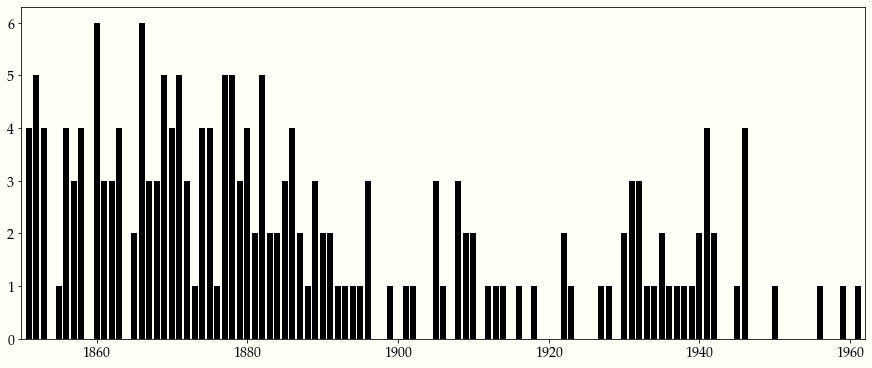

In [33]:
disasters_array = np.array(
    [4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6, 3, 3, 5, 4, 5, 3, 
     1, 4, 4, 1, 5, 5, 3, 4, 2, 5, 2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 
     1, 3, 0, 0, 1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1, 0, 1, 
     0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2, 3, 3, 1, 1, 2, 1, 1, 1, 
     1, 2, 4, 2, 0, 0, 1, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 
     1])
years = np.arange(1851, 1962, dtype=int)

fig, ax = plt.subplots()
ax.vlines(years, 0, disasters_array, lw=6)
ax.set_xlim(years.min() - 1, years.max() + 1)
ax.set_ylim(bottom=0);

### Writing down the model and computing conditional distributions

It is perhaps easiest to write the model as a PyMC3 model. In notation, we might write

$$
y_t \sim \operatorname{Poisson}(\lambda_t), t=1851, \ldots, 1962 \\
\lambda_t = \left\{ \begin{array}{}\lambda_1 \text{ for } t \leq \tau \\ \lambda_2 \text{ for } t > \tau \end{array}\right. \\
\lambda_j \sim \operatorname{Gamma}(1, 10) \\
\tau \sim \operatorname{DiscreteUniform}(1851, 1962)
$$


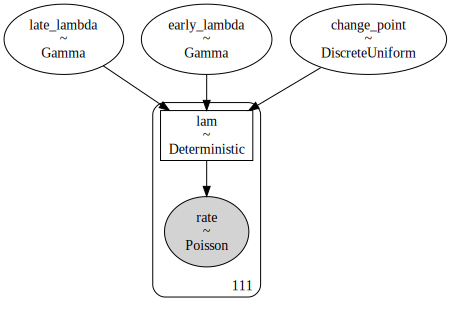

In [34]:
import pymc3 as pm

def coal_disaster_model():
    with pm.Model() as model:
        early_lambda = pm.Gamma('early_lambda', 1, 10)
        late_lambda = pm.Gamma('late_lambda', 1, 10)
        change_point = pm.DiscreteUniform('change_point', 1851, 1962)
        lam = pm.Deterministic('lam', pm.math.where(years > change_point, late_lambda, early_lambda))
        pm.Poisson('rate', lam, observed=disasters_array)
    return model

pm.model_to_graphviz(coal_disaster_model())

Now we need to go out and compute the conditional distributions:

$$
p(\tau | \lambda_1, \lambda_2, y_t) \\ 
p(\lambda_1 | \tau, \lambda_2, y_t) \\ 
p(\lambda_2 | \tau, \lambda_1, y_t)
$$

In this case, we can do some arithmetic, look up these distributions, and compute

$$
p(\tau | \lambda_1, \lambda_2, y_t) = \operatorname{Categorical}\left( \frac{\lambda_1^{\sum_{t=1851}^{\tau} y_t +\alpha-1} e^{-(\beta+\tau)\lambda_1} \lambda_2^{\sum_{t=\tau+1}^{1962} y_i + \alpha-1} e^{-\beta\lambda_2}}{\sum_{k=1851}^{1962} \lambda_1^{\sum_{t=1851}^{\tau} y_t +\alpha-1} e^{-(\beta+\tau)\lambda_1} \lambda_2^{\sum_{t=\tau+1}^{1962} y_i + \alpha-1} e^{-\beta\lambda_2}} \right) \\ 
p(\lambda_1 | \tau, \lambda_2, y_t) = \operatorname{Gamma}\left(\sum_{t=1851}^{\tau} y_t + \alpha, \tau + \beta\right)\\ 
p(\lambda_2 | \tau, \lambda_1, y_t) = \operatorname{Gamma}\left(\sum_{t=\tau + 1}^{1962} y_t + \alpha, 1962 - \tau + \beta\right)
$$

So far so good! Now here's an implementation!

In [35]:
def gibbs_sample_disaster(samples, tau=1900, early_lambda=6, late_lambda=2):
    """Can supply different initial conditions!"""
    draws = np.empty((3, samples))
    gamma_pdf = lambda lam, a, b: lam**(a-1) * np.exp(-b*lam)
    n_years = disasters_array.shape[0]
    years = np.arange(1851, 1962, dtype=int)
    draws = []
    while len(draws) < samples:
        # update early_lambda
        early_lambda = np.random.gamma(disasters_array[:tau - 1851].sum() + 1, 1 / (tau - 1851 + 10))
        draws.append([early_lambda, late_lambda, tau])
        
        # update late_lambda
        late_lambda = np.random.gamma(disasters_array[tau - 1851 + 1:].sum() + 1, 1 / (1962 - tau + 10))
        draws.append([early_lambda, late_lambda, tau])
        
        # update tau
        tau_probs = np.empty(n_years)
        for t in range(n_years):
            tau_probs[t] = (gamma_pdf(early_lambda, disasters_array[:t].sum() + 1, t + 10) *
                            gamma_pdf(late_lambda, disasters_array[t:].sum() + 1, n_years - t + 10))
        tau = np.random.choice(years, p=tau_probs / tau_probs.sum())
        draws.append([early_lambda, late_lambda, tau])
    return np.array(draws)[:samples]


### Checking our work

We compare the Gibbs sampler to the PyMC3 model -- this one goes a bit faster, but maybe it took me longer to write!

In [36]:
%%time
draws = gibbs_sample_disaster(1000)
draws.mean(axis=0) # early_lambda, late_lambda, change_point

CPU times: user 918 ms, sys: 19.7 ms, total: 937 ms
Wall time: 1.24 s


array([2.45569740e+00, 7.95103382e-01, 1.89304200e+03])

In [37]:
%%time
with coal_disaster_model():
    trace = pm.sample()

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [late_lambda, early_lambda]
>Metropolis: [change_point]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
The number of effective samples is smaller than 25% for some parameters.


CPU times: user 5.53 s, sys: 504 ms, total: 6.03 s
Wall time: 13.1 s


In [38]:
pm.summary(trace, varnames=['early_lambda', 'late_lambda', 'change_point', ])

/Users/twiecki/miniconda3/envs/bayes_course/lib/python3.7/site-packages/pymc3/stats/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)
/Users/twiecki/miniconda3/envs/bayes_course/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean     sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  \
early_lambda     2.476  0.233     2.052     2.923      0.006    0.004   
late_lambda      0.815  0.103     0.625     1.006      0.003    0.002   
change_point  1892.180  2.798  1886.000  1896.000      0.163    0.116   

              ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
early_lambda    1361.0  1361.0    1357.0    1337.0   1.00  
late_lambda     1136.0  1136.0    1120.0    1626.0   1.00  
change_point     293.0   293.0     307.0     444.0   1.01